In [2]:
!pip install numpy pandas seaborn matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install transformers torch


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torchvision import transforms
from PIL import Image

from os import path
import os

import cv2


# Prediction and Histogram

Predicted class: cow


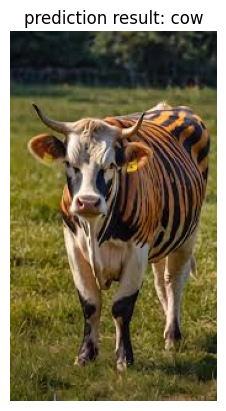

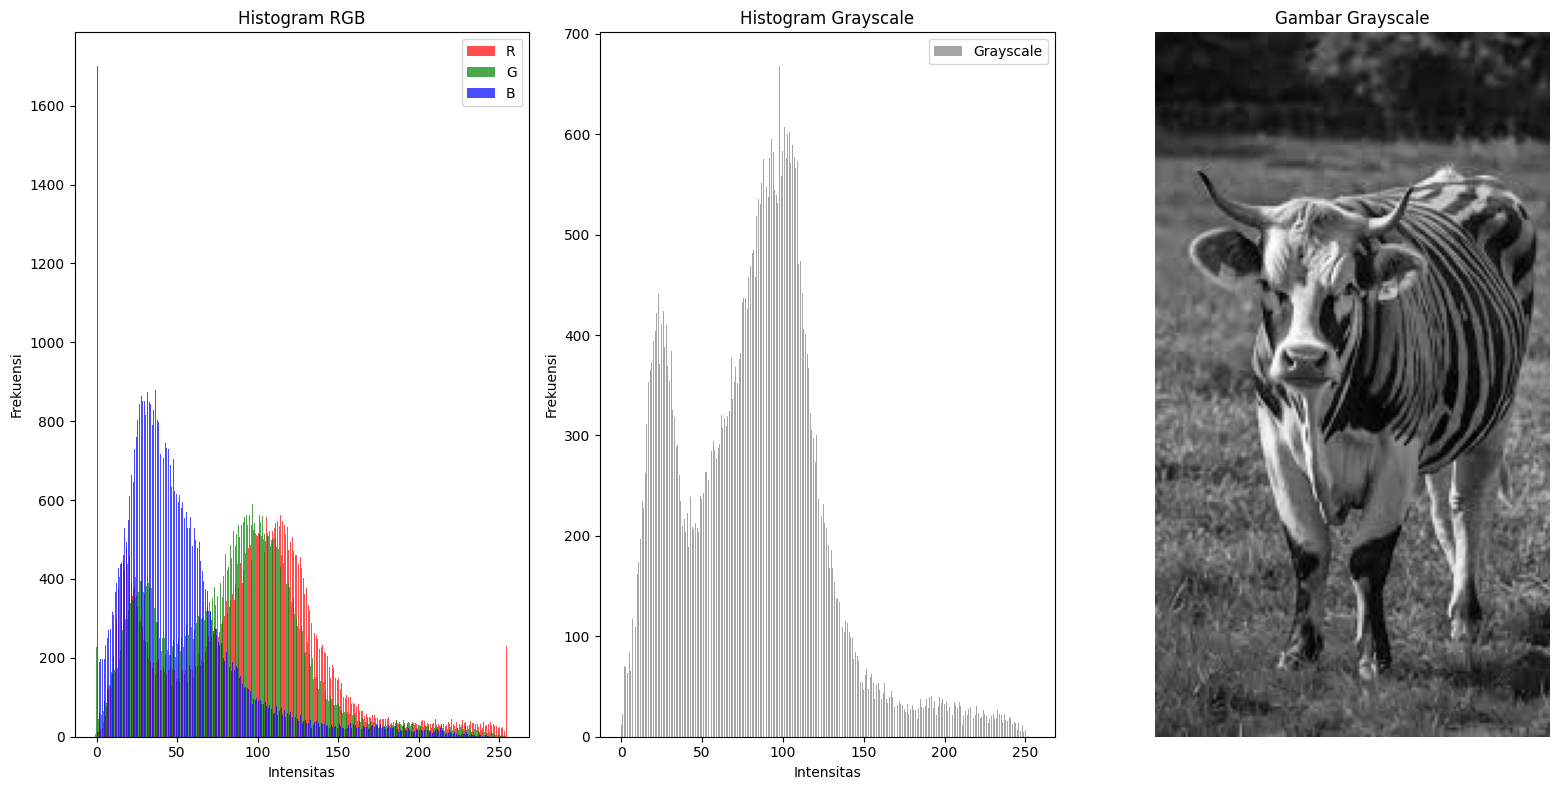

In [12]:
def load_model_and_processor(model_name: str):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(model_name)
    return processor, model

def predict_animal(processor, model, image_path: str):
    # Load an image
    image = Image.open(image_path)
    
    # Preprocess the image
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits

    # Predict the class with the highest probability
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]
    
    return image, predicted_class

def display_histograms(r, g, b, gray, gray_image):
    intensities = list(range(256))
    bar_width = 0.6

    plt.figure(figsize=(16, 8))

    # RGB Histogram
    plt.subplot(1, 3, 1)
    plt.bar([i - bar_width for i in intensities], r, width=bar_width, color='r', alpha=0.7, label='R')
    plt.bar(intensities, g, width=bar_width, color='g', alpha=0.7, label='G')
    plt.bar([i + bar_width for i in intensities], b, width=bar_width, color='b', alpha=0.7, label='B')
    plt.title('Histogram RGB')
    plt.xlabel('Intensitas')
    plt.ylabel('Frekuensi')
    plt.legend()

    # Grayscale Histogram
    plt.subplot(1, 3, 2)
    plt.bar(intensities, gray, width=bar_width, color='gray', alpha=0.7, label='Grayscale')
    plt.title('Histogram Grayscale')
    plt.xlabel('Intensitas')
    plt.ylabel('Frekuensi')
    plt.legend()

    # Display Grayscale Image
    plt.subplot(1, 3, 3)
    plt.imshow(gray_image, cmap='gray')
    plt.title('Gambar Grayscale')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def generate_histograms(image):
    pixels = image.load()
    width, height = image.size

    r_hist = [0] * 256
    g_hist = [0] * 256
    b_hist = [0] * 256
    gray_hist = [0] * 256

    # Create grayscale image
    gray_image = Image.new('L', (width, height))
    pixels_gray = gray_image.load()

    # Process the image
    for x in range(width):
        for y in range(height):
            r = pixels[x, y][0]
            g = pixels[x, y][1]
            b = pixels[x, y][2]
            gray = int(0.299 * r + 0.587 * g + 0.114 * b)
            r_hist[r] += 1
            g_hist[g] += 1
            b_hist[b] += 1
            gray_hist[gray] += 1
            pixels_gray[x, y] = gray

    return r_hist, g_hist, b_hist, gray_hist, gray_image

def display_image_with_prediction(image, predicted_class):
    plt.imshow(image)
    plt.title(f"prediction result: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example usage:
model_name = "NaveenCidc/animals"
image_path = "./Image/cow.png"

processor, model = load_model_and_processor(model_name)
image, predicted_class = predict_animal(processor, model, image_path)

print(f"Predicted class: {predicted_class}")

display_image_with_prediction(image, predicted_class)

# Generate histograms and display
r_hist, g_hist, b_hist, gray_hist, gray_image = generate_histograms(image)
display_histograms(r_hist, g_hist, b_hist, gray_hist, gray_image)

# Morfologi Operation

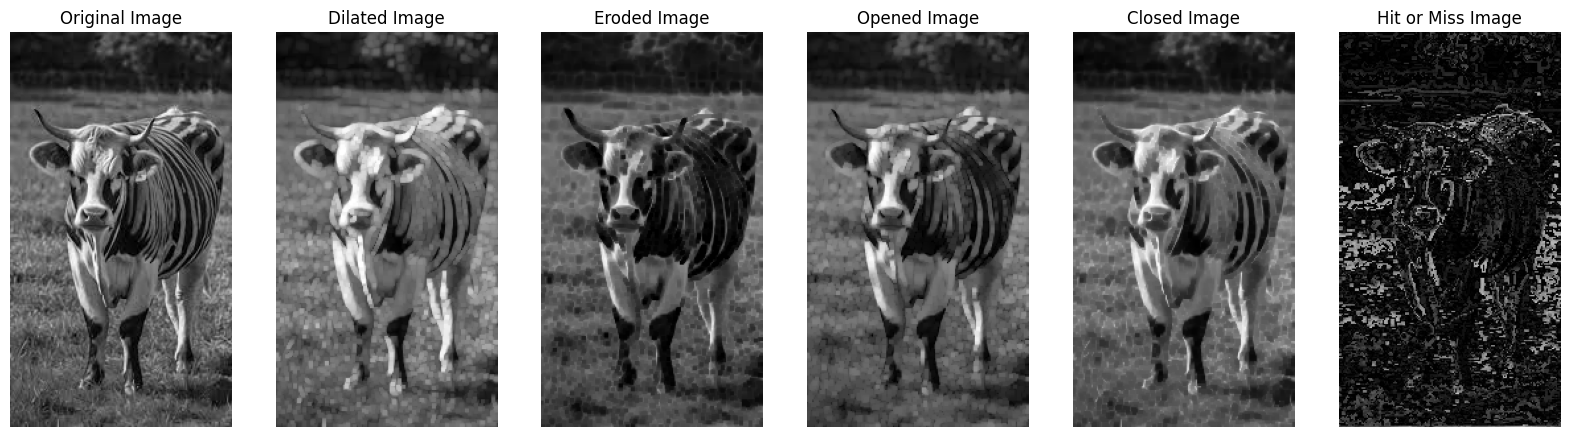

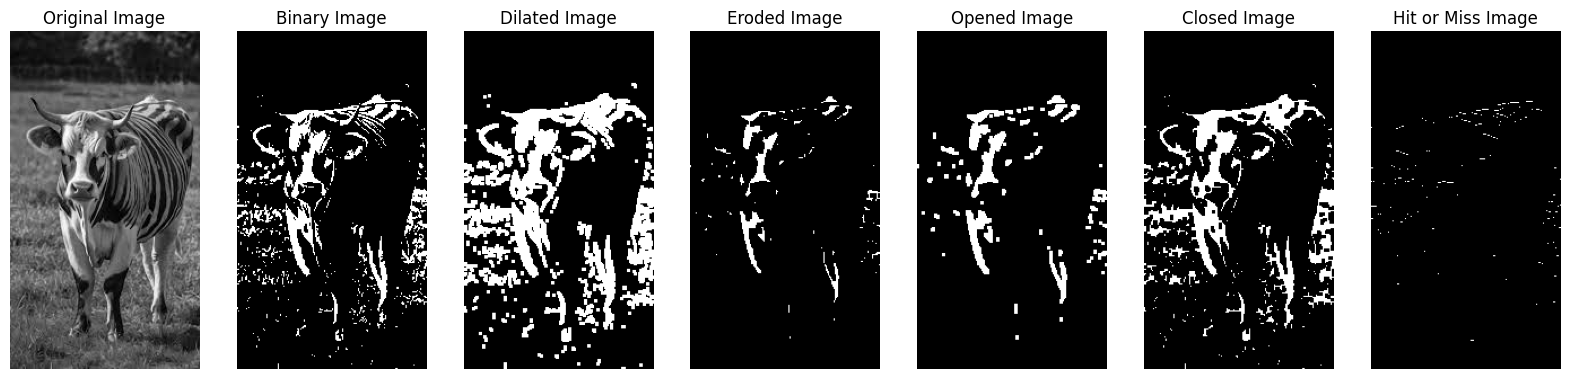

In [13]:
def remove_background(image):
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return binary_image

def apply_dilation(image, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image = cv2.dilate(image, kernel, iterations=iterations)
    return dilated_image

def apply_erosion(image, kernel_size=3, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=iterations)
    return eroded_image

def apply_opening(image, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opened_image

def apply_closing(image, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closed_image

def apply_hit_or_miss(image, kernel):
    hit_or_miss_image = cv2.morphologyEx(image, cv2.MORPH_HITMISS, kernel)
    return hit_or_miss_image

def display_images_horizontally(images, titles):
    """Menampilkan gambar-gambar secara horizontal."""
    plt.figure(figsize=(20, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

def process_image_with_background(image_path):
    image = cv2.imread(image_path, 0)
    
    # Terapkan operasi morfologi
    dilated = apply_dilation(image)
    eroded = apply_erosion(image)
    opened = apply_opening(image)
    closed = apply_closing(image)

    # Untuk hit or miss, kernel harus memiliki elemen 1, 0, dan -1
    kernel_hit_or_miss = np.array([[1, 1, 1],
                                   [0, 1, 0],
                                   [-1, -1, -1]], dtype=np.int8)
    hit_or_miss = apply_hit_or_miss(image, kernel_hit_or_miss)

    # Tampilkan hasil secara berdampingan
    images = [image, dilated, eroded, opened, closed, hit_or_miss]
    titles = ["Original Image", "Dilated Image", "Eroded Image", "Opened Image", "Closed Image", "Hit or Miss Image"]
    display_images_horizontally(images, titles)

def process_image_without_background(image_path):
    image = cv2.imread(image_path, 0) 

    # Hapus latar belakang
    binary_image = remove_background(image)

    # Terapkan operasi morfologi
    dilated = apply_dilation(binary_image)
    eroded = apply_erosion(binary_image)
    opened = apply_opening(binary_image)
    closed = apply_closing(binary_image)

    # Untuk hit or miss, kernel harus memiliki elemen 1, 0, dan -1
    kernel_hit_or_miss = np.array([[1, 1, 1],
                                   [0, 1, 0],
                                   [-1, -1, -1]], dtype=np.int8)
    hit_or_miss = apply_hit_or_miss(binary_image, kernel_hit_or_miss)

    # Tampilkan hasil secara berdampingan
    images = [image, binary_image, dilated, eroded, opened, closed, hit_or_miss]
    titles = ["Original Image", "Binary Image", "Dilated Image", "Eroded Image", "Opened Image", "Closed Image", "Hit or Miss Image"]
    display_images_horizontally(images, titles)

# Contoh penggunaan
image_path = "./Image/cow.png"

# Proses gambar tanpa menghapus latar belakang
process_image_with_background(image_path)

# Proses gambar dengan menghapus latar belakang
process_image_without_background(image_path)

In [14]:
class ImageConvolution:
    def __init__(self, img_path, model_name):
        self.mem_image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        self.processor, self.model = self.load_model_and_processor(model_name)
        if self.mem_image is None:
            raise Exception('No Image Found: ' + img_path)

    def load_model_and_processor(self, model_name: str):
        processor = AutoImageProcessor.from_pretrained(model_name)
        model = AutoModelForImageClassification.from_pretrained(model_name)
        return processor, model

    def rotate_image(self, angle):
        # Get image dimensions and calculate the center for rotation
        (h, w) = self.mem_image.shape[:2]
        center = (w // 2, h // 2)
        
        # Get the rotation matrix and rotate the image
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(self.mem_image, rotation_matrix, (w, h))
        
        return rotated_image
    
    # Method to predict animal after convolution
    def predict_animal(self, image):
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        inputs = self.processor(images=pil_image, return_tensors="pt")
        outputs = self.model(**inputs)
        logits = outputs.logits

        # Predict the class with the highest probability
        predicted_class_idx = logits.argmax(-1).item()
        predicted_class = self.model.config.id2label[predicted_class_idx]
        
        return predicted_class

    # Apply a convolution after rotating the image by various angles
    def apply_convolution(self, kernel, title):
        angles = [0, 45, 90, 135]  # Rotation angles in degrees
        fig, axs = plt.subplots(2, len(angles), figsize=(5 * len(angles), 10))  # Horizontal layout

        for i, angle in enumerate(angles):
            rotated_image = self.rotate_image(angle)
            resultant_image = cv2.filter2D(rotated_image, -1, kernel)
            
            # Predict animal type after convolution
            predicted_class = self.predict_animal(resultant_image)

            # Display the original and convolved images side by side for each angle
            axs[0, i].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
            axs[0, i].set_title(f'Rotated Image (Angle: {angle}°)')
            axs[1, i].imshow(cv2.cvtColor(resultant_image, cv2.COLOR_BGR2RGB))
            axs[1, i].set_title(f'{title} Image (Angle: {angle}°) \n Predicted: {predicted_class}')

        fig.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

    def blur(self):
        kernel = np.ones((9,9))/81
        self.apply_convolution(kernel, "Blurred")

    def edge_detection(self):
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        self.apply_convolution(kernel, "Edge Detection")

    def sharpen(self):
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        self.apply_convolution(kernel, "Sharpened")

    def outline(self):
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        angles = [0, 45, 90, 135]
        
        fig, axs = plt.subplots(2, len(angles), figsize=(5 * len(angles), 10))  # Horizontal layout

        for i, angle in enumerate(angles):
            rotated_image = self.rotate_image(angle)
            gray_scale_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
            resultant_image = cv2.filter2D(gray_scale_image, -1, kernel)
            resultant_image = cv2.bitwise_not(resultant_image)

            # Predict animal type after outlining
            predicted_class = self.predict_animal(rotated_image)

            # Display the rotated and outlined images side by side
            axs[0, i].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
            axs[0, i].set_title(f'Rotated Image (Angle: {angle}°)')
            axs[1, i].imshow(resultant_image, cmap='gray')
            axs[1, i].set_title(f'Outline Image (Angle: {angle}°) \n Predicted: {predicted_class}')

        fig.suptitle("Outline", fontsize=16)
        plt.tight_layout()
        plt.show()

    def sobel(self):
        kernel_h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        kernel_v = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        angles = [0, 45, 90, 135]
        
        fig, axs = plt.subplots(2, len(angles), figsize=(5 * len(angles), 10))  # Horizontal layout

        for i, angle in enumerate(angles):
            rotated_image = self.rotate_image(angle)
            resultant_image_h = cv2.filter2D(rotated_image, -1, kernel_h)
            resultant_image_v = cv2.filter2D(rotated_image, -1, kernel_v)
            resultant_image = cv2.bitwise_or(resultant_image_h, resultant_image_v)

            # Predict animal type after Sobel edge detection
            predicted_class = self.predict_animal(resultant_image)

            # Display the rotated and Sobel edge-detected images side by side
            axs[0, i].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
            axs[0, i].set_title(f'Rotated Image (Angle: {angle}°)')
            axs[1, i].imshow(cv2.cvtColor(resultant_image, cv2.COLOR_BGR2RGB))
            axs[1, i].set_title(f'Sobel Image (Angle: {angle}°) \n Predicted: {predicted_class}')

        fig.suptitle("Sobel Edge Detection", fontsize=16)
        plt.tight_layout()
        plt.show()


# Image Convolution

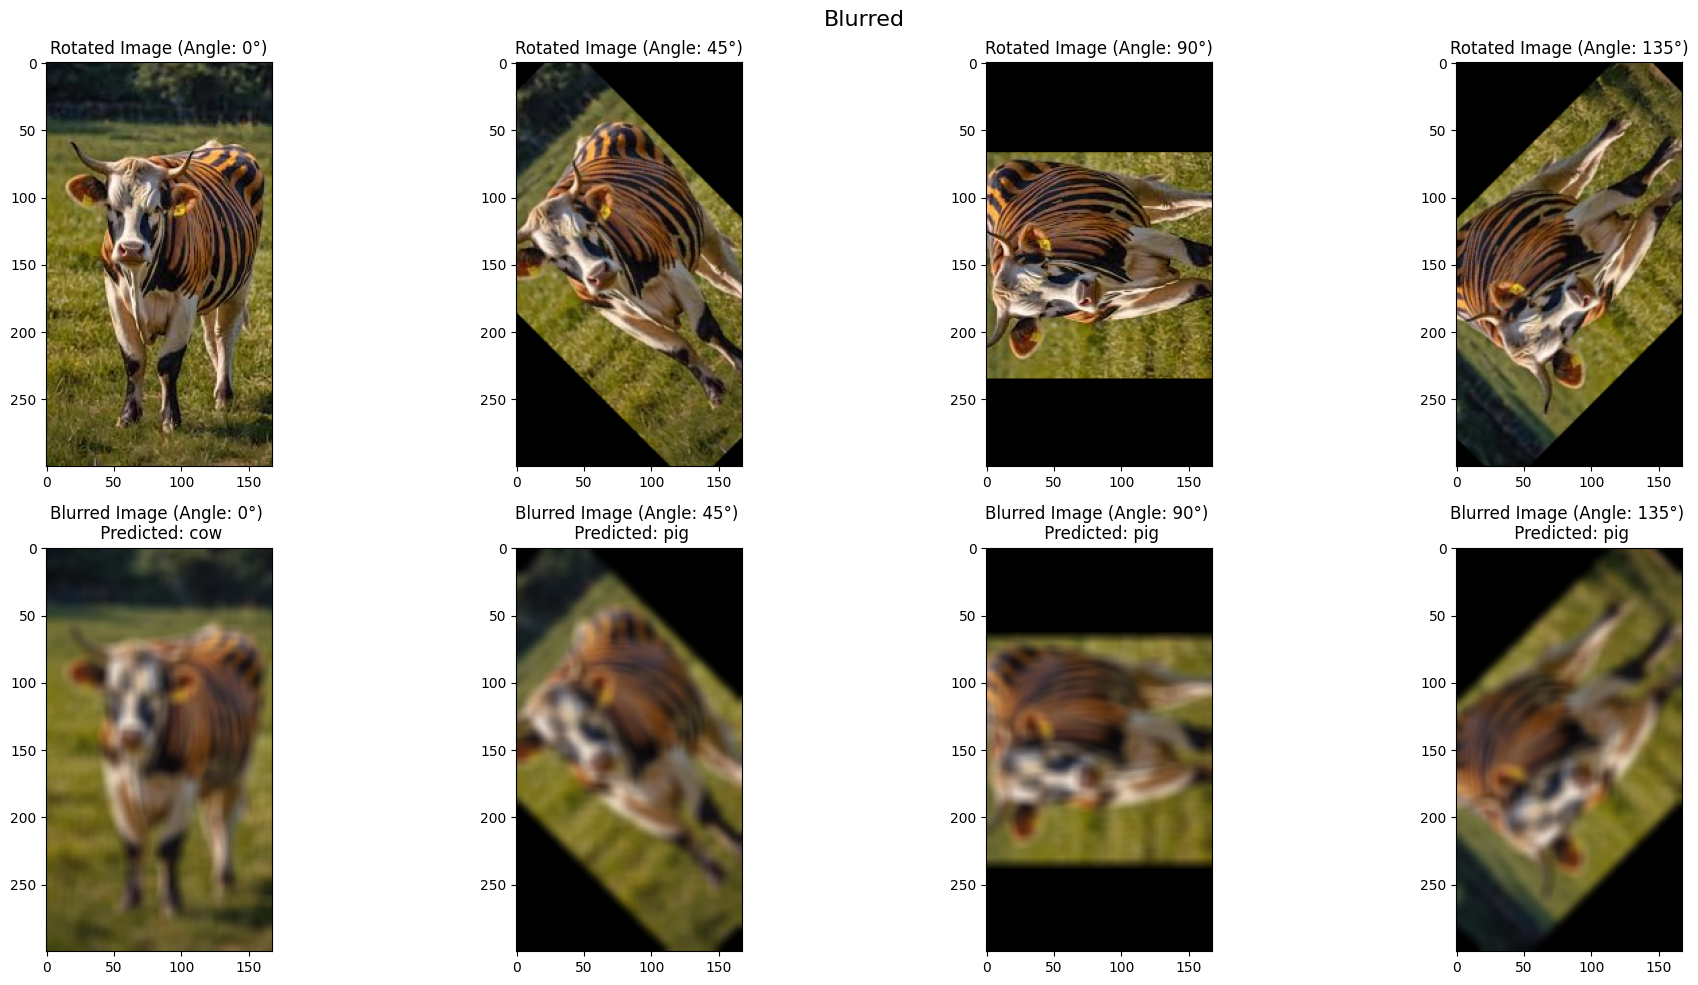

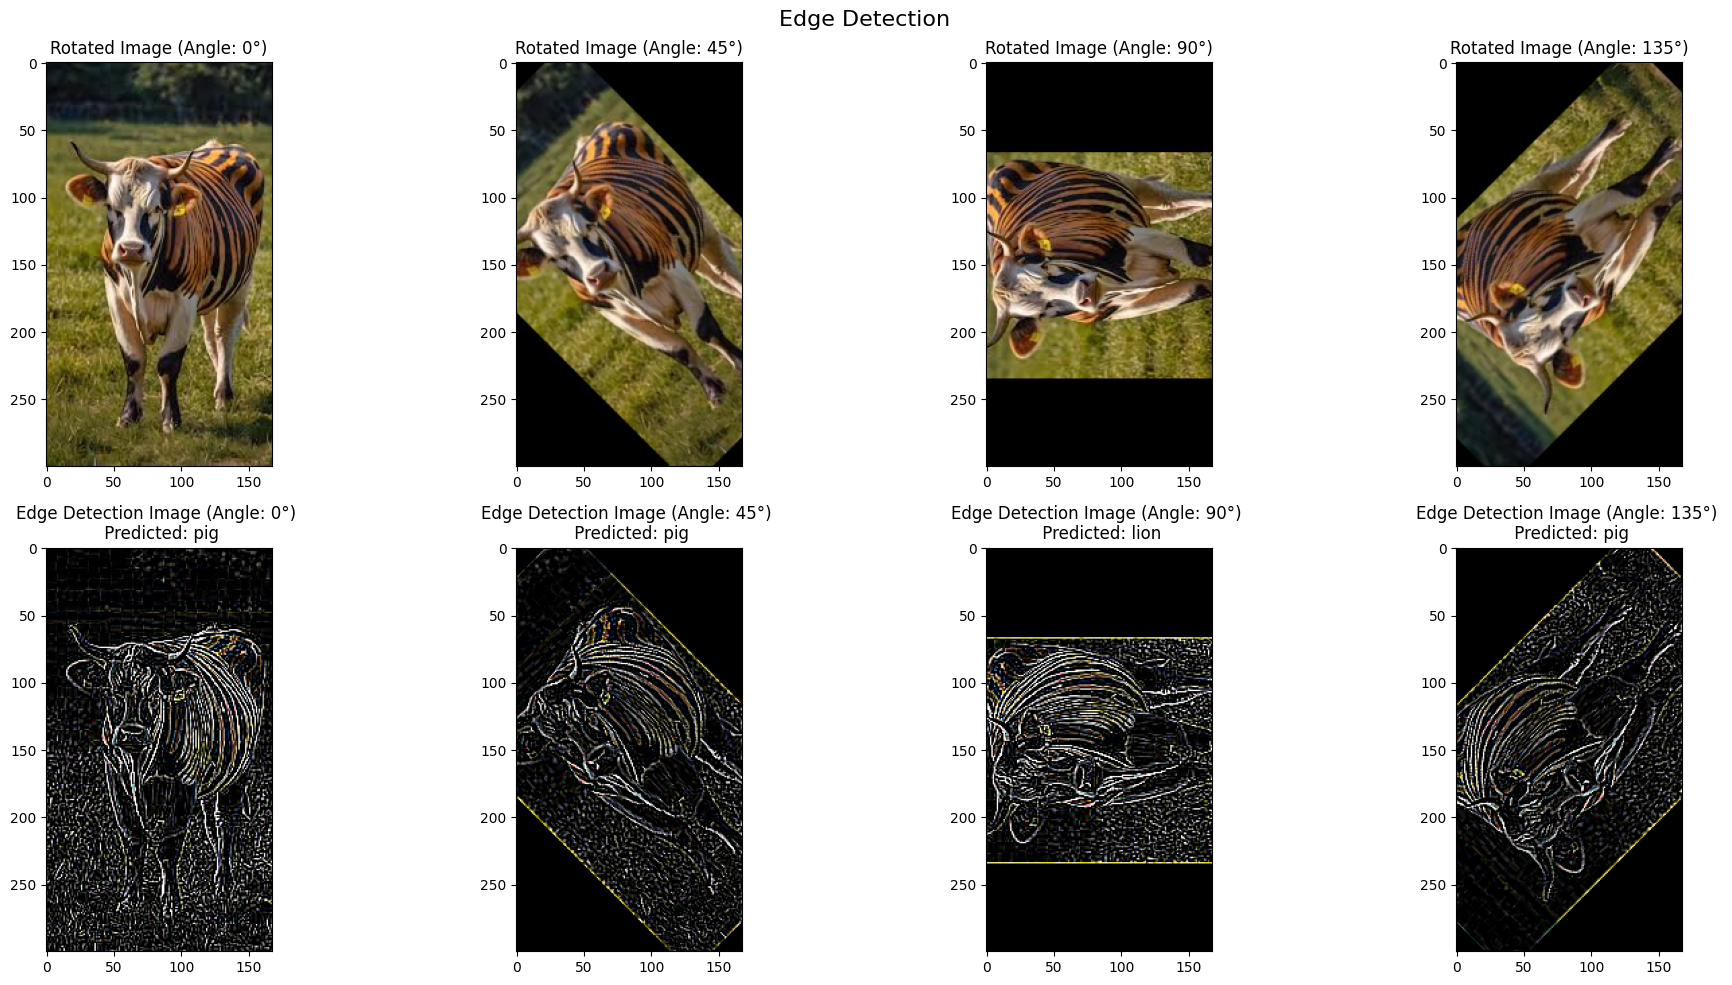

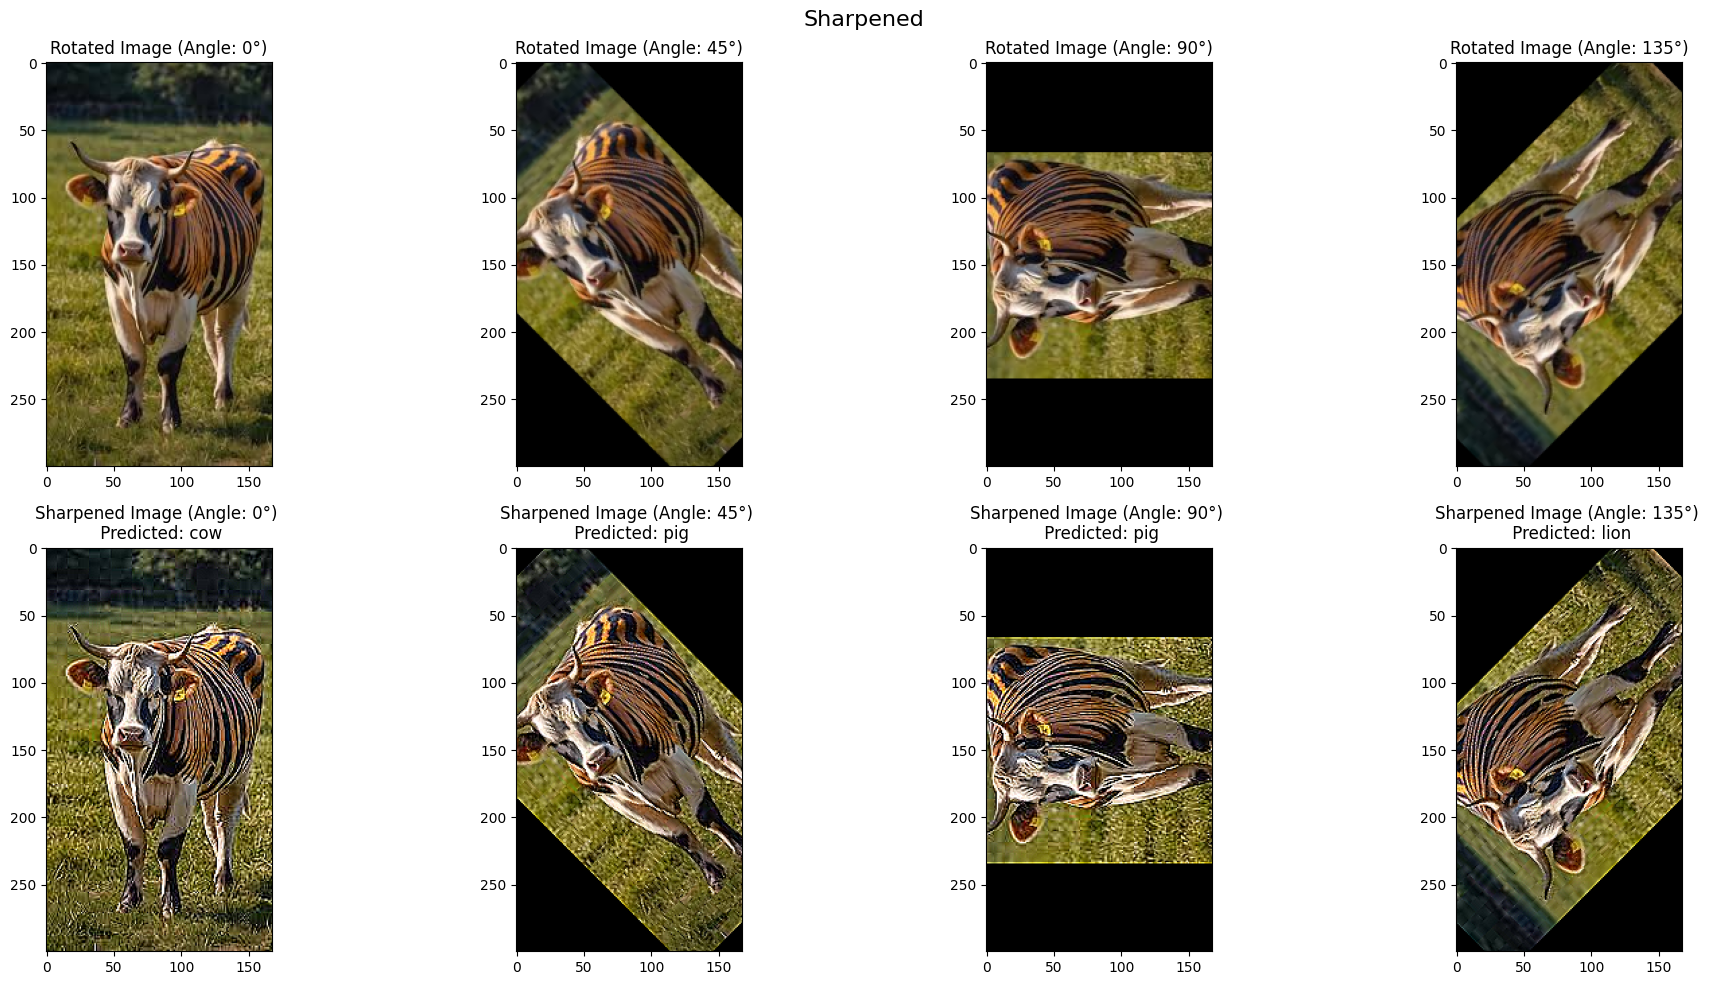

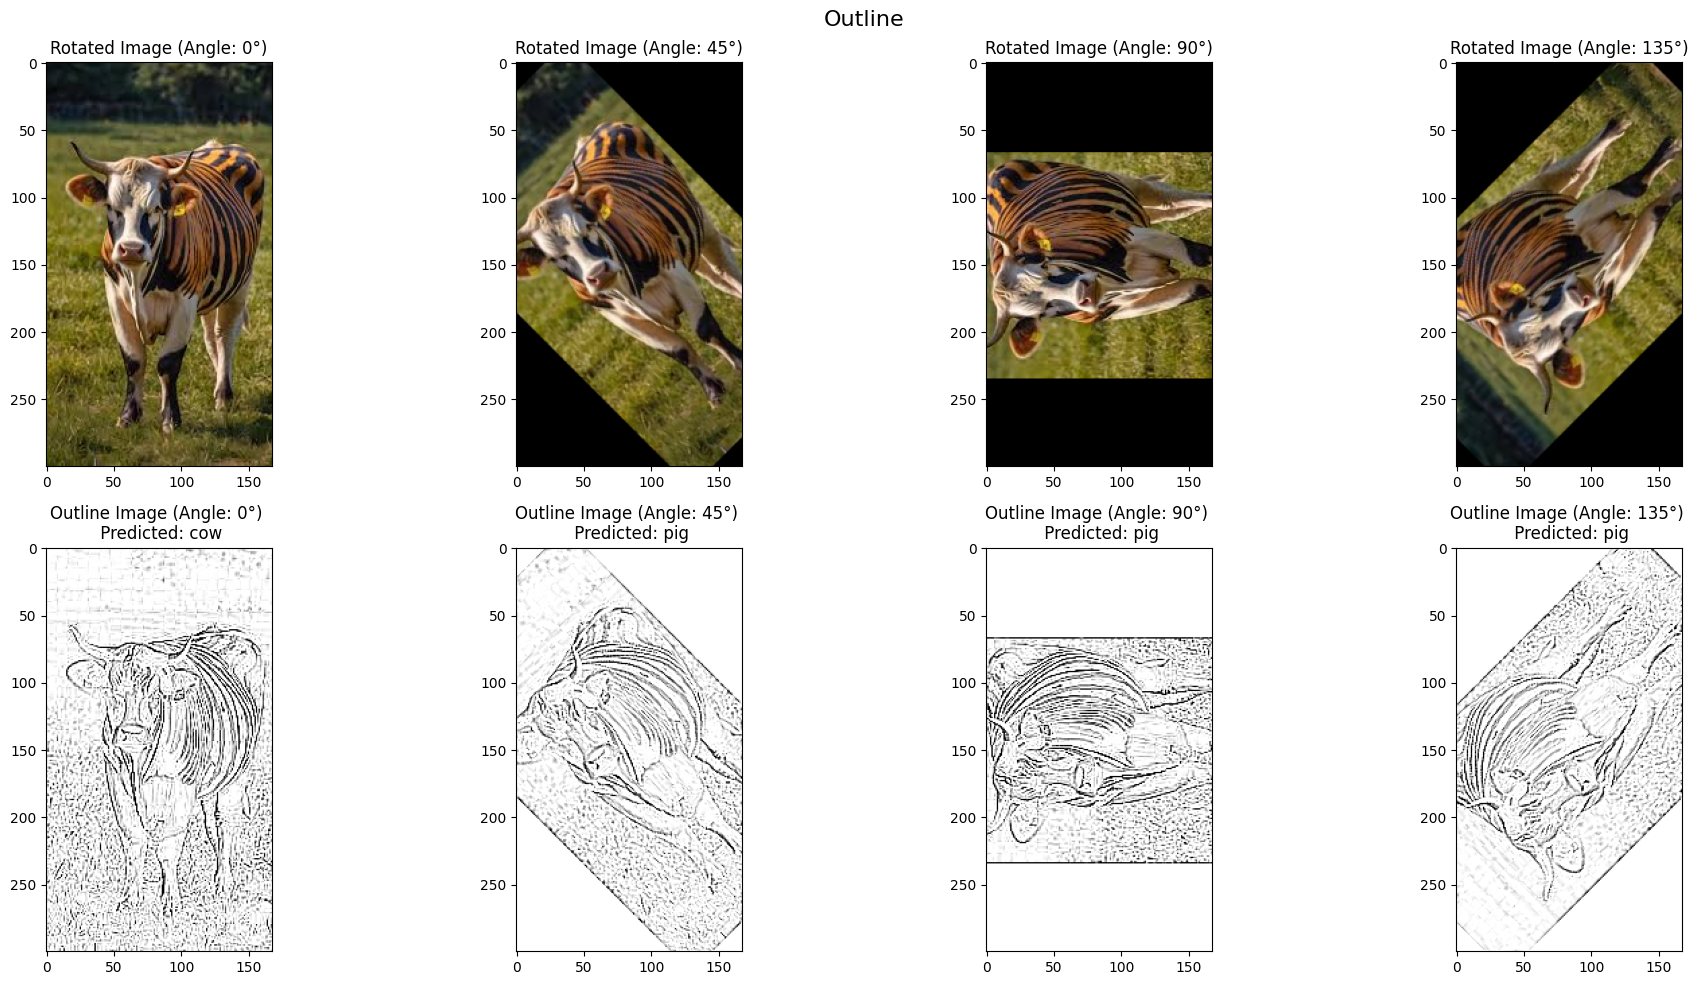

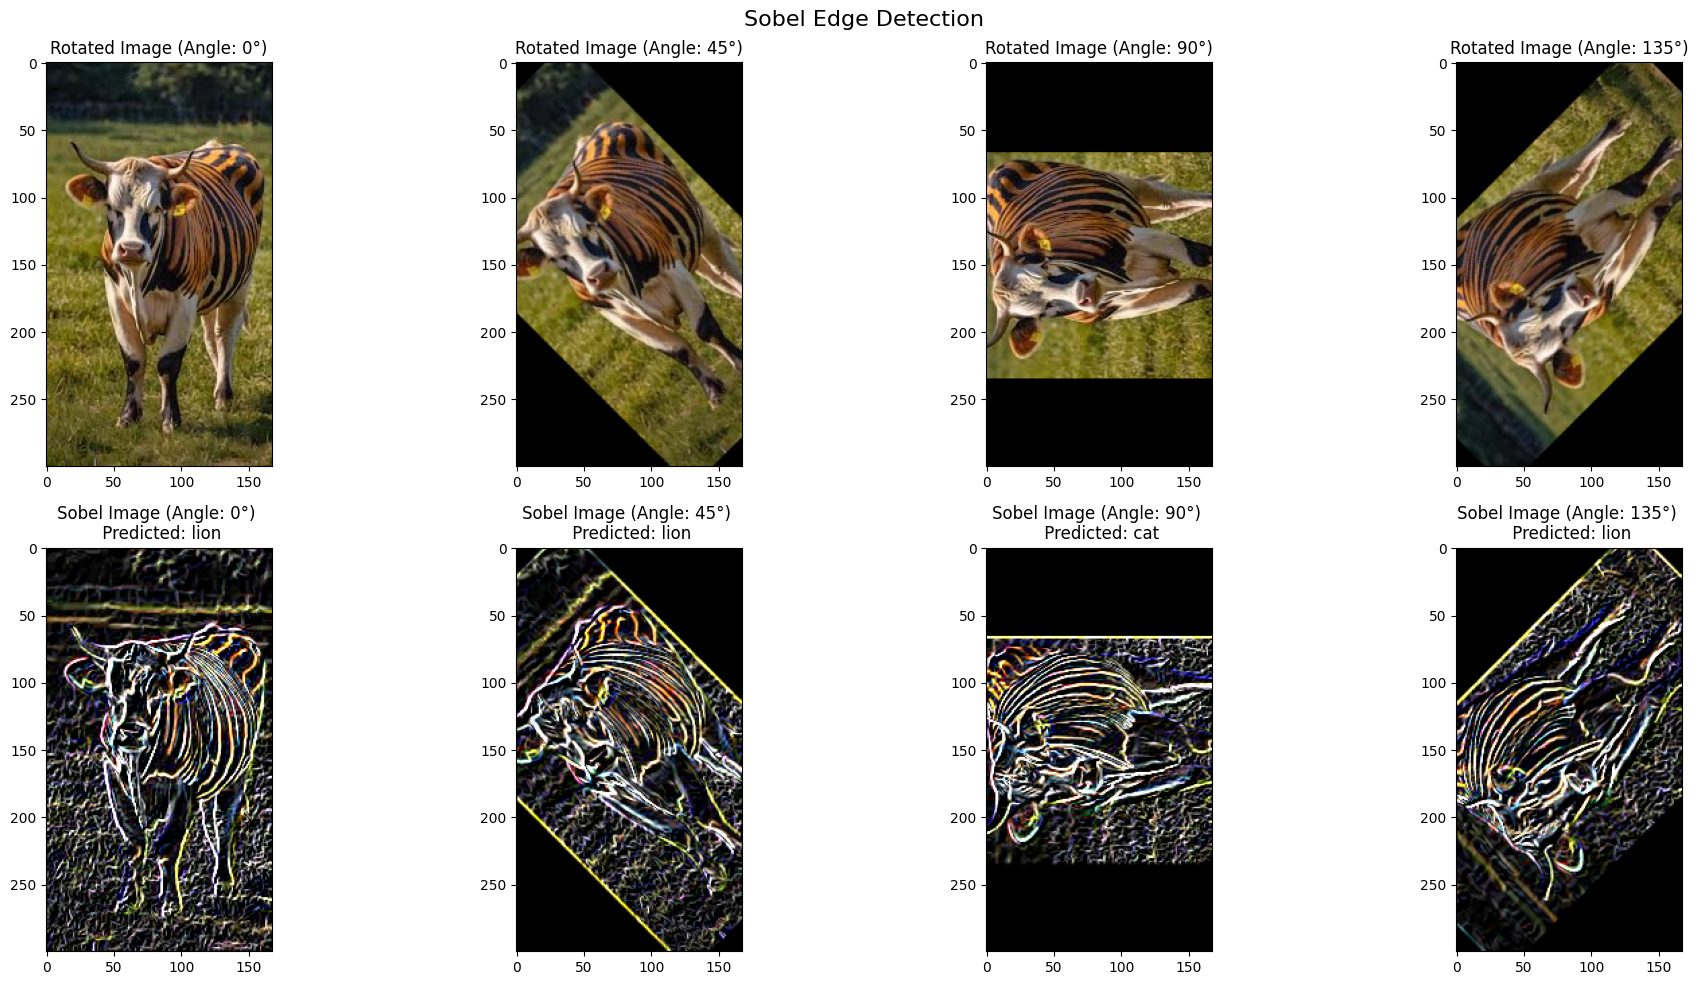

In [15]:
# usage:
model_name = "NaveenCidc/animals"
image_path = "./Image/cow.png"

# Initialize ImageConvolution with model
image_conv = ImageConvolution(image_path, model_name)

# Apply different convolutions and display predictions
image_conv.blur()
image_conv.edge_detection()
image_conv.sharpen()
image_conv.outline()
image_conv.sobel()

# Fast Fourier transform (FFT)

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider

# Load and preprocess the image
image = cv2.imread('./Image/cow.png', 0)
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# Function to apply filters and display images
def apply_filter(low_cutoff, high_cutoff, orientation_center, orientation_width, depiction, zoom):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # Create a mask based on spatial frequency cutoffs and orientation
    mask = np.zeros((rows, cols), np.float32)
    for u in range(rows):
        for v in range(cols):
            # Compute distance from center
            du = u - crow
            dv = v - ccol
            d = np.sqrt(du**2 + dv**2)
            
            # Compute angle for orientation
            angle = np.arctan2(dv, du) * (180 / np.pi)
            
            # Apply low and high frequency cutoff
            if low_cutoff <= d <= high_cutoff:
                # Apply orientation filtering
                if abs(angle - orientation_center) <= orientation_width / 2:
                    mask[u, v] = 1
    
    # Apply mask and inverse FFT
    fshift_filtered = fshift * mask
    filtered_spectrum = np.log(np.abs(fshift_filtered) + 1)
    f_ishift = np.fft.ifftshift(fshift_filtered)
    image_back = np.abs(np.fft.ifft2(f_ishift))
    
    # Amplitude Spectrum
    amplitude_spectrum = np.log(np.abs(fshift) + 1)
    if depiction == 'Log-Polar':
        center = (cols // 2, rows // 2)
        max_radius = np.sqrt(center[0]**2 + center[1]**2)
        amplitude_spectrum = cv2.logPolar(amplitude_spectrum, center, max_radius / np.log(max_radius), cv2.INTER_LINEAR)
    
    # Apply zoom to amplitude spectrum
    h, w = amplitude_spectrum.shape
    ch, cw = h // 2, w // 2
    zoomed_spectrum = amplitude_spectrum[ch - h // (2 * zoom): ch + h // (2 * zoom), cw - w // (2 * zoom): cw + w // (2 * zoom)]
    zoomed_spectrum = cv2.resize(zoomed_spectrum, (w, h), interpolation=cv2.INTER_LINEAR)

    # Plotting results
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    # Original Image
    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')
    
    # Amplitude Spectrum
    axs[0, 1].imshow(zoomed_spectrum, cmap='gray')
    axs[0, 1].set_title(f'Amplitude Spectrum ({depiction}, {zoom}x)')
    axs[0, 1].axis('off')
    
    # Filtered Spectrum
    axs[1, 0].imshow(filtered_spectrum, cmap='gray')
    axs[1, 0].set_title('Filtered Spectrum')
    axs[1, 0].axis('off')
    
    # Output Image
    axs[1, 1].imshow(image_back, cmap='gray')
    axs[1, 1].set_title('Output Image')
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Interactive controls
interact(
    apply_filter,
    low_cutoff=FloatSlider(value=10, min=0, max=100, step=1, description='Low Cutoff'),
    high_cutoff=FloatSlider(value=100, min=0, max=200, step=1, description='High Cutoff'),
    orientation_center=FloatSlider(value=0, min=-360, max=360, step=1, description='Orientation Center'),
    orientation_width=FloatSlider(value=90, min=0, max=360, step=1, description='Orientation Width'),
    depiction=Dropdown(options=['Cartesian', 'Log-Polar'], value='Cartesian', description='Depiction'),
    zoom=IntSlider(value=1, min=1, max=4, step=1, description='Zoom')
)

interactive(children=(FloatSlider(value=10.0, description='Low Cutoff', step=1.0), FloatSlider(value=100.0, de…

<function __main__.apply_filter(low_cutoff, high_cutoff, orientation_center, orientation_width, depiction, zoom)>